# Activity Directions
Download the dataset here: https://archive.ics.uci.edu/ml/datasets/AbaloneLinks to an external site.

The data and variables names are in different files; you will likely need them both. The goal here is to predict the age of the abalone using the other variables in the dataset because the traditional method for aging these organisms is boring and tedious.

There are two challenges (in my opinion):

1. You should try to build the best, stacking-based model(s) to predict age.

2. The UC Irvine Machine Learning Repository classifies this dataset as a "classification" dataset, but age is stored as a numeric (albeit discrete-valued) variable. So, I think it could maybe be reasonable to treat this as a regression problem. It's up to you!

How does your work here compare to your results with bagging?!

# Notes
- All models use the whole data set, no sampling. Then use predictions from base models on meta model to best combine the predictions of the base models.
- Base models are often complex and diverse where meta models are simple (ie linear regression).

# Process
## import data

In [1]:
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features.copy()
# # Converts 'M', 'F', 'I' to integers
le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])

y = abalone.data.targets.values.ravel() 

X

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,2,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,2,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


# Stacking Model

In [11]:
import numpy as np
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Use regression models only
models = [
    ('knn', KNeighborsRegressor()),
    ('svr', SVR())
]

stack = StackingRegressor(
    estimators=models,
    final_estimator=LinearRegression(),  # Meta-model
    passthrough=True,                    
    cv=5,
    n_jobs=-1
)

# Cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(stack, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores2 = cross_val_score(stack, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)


# Report results
print('MAE: %.3f (%.3f)' % (-np.mean(scores), np.std(scores)))
print('MSE: %.3f (%.3f)' % (-np.mean(scores2), np.std(scores2)))

MAE: 1.532 (0.076)
MSE: 4.596 (0.551)


# Compare Models

In [12]:
from sklearn.model_selection import cross_val_score

# Base models
knn = KNeighborsRegressor()
svr = SVR()

# List of models
model_list = [
    ('KNN', knn),
    ('SVR', svr),
    ('Stacking', stack)
]

# Evaluate each
mae_results = {}
mse_results = {}

for name, model in model_list:
    mae_scores = -cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    mse_scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    
    mae_results[name] = mae_scores
    mse_results[name] = mse_scores


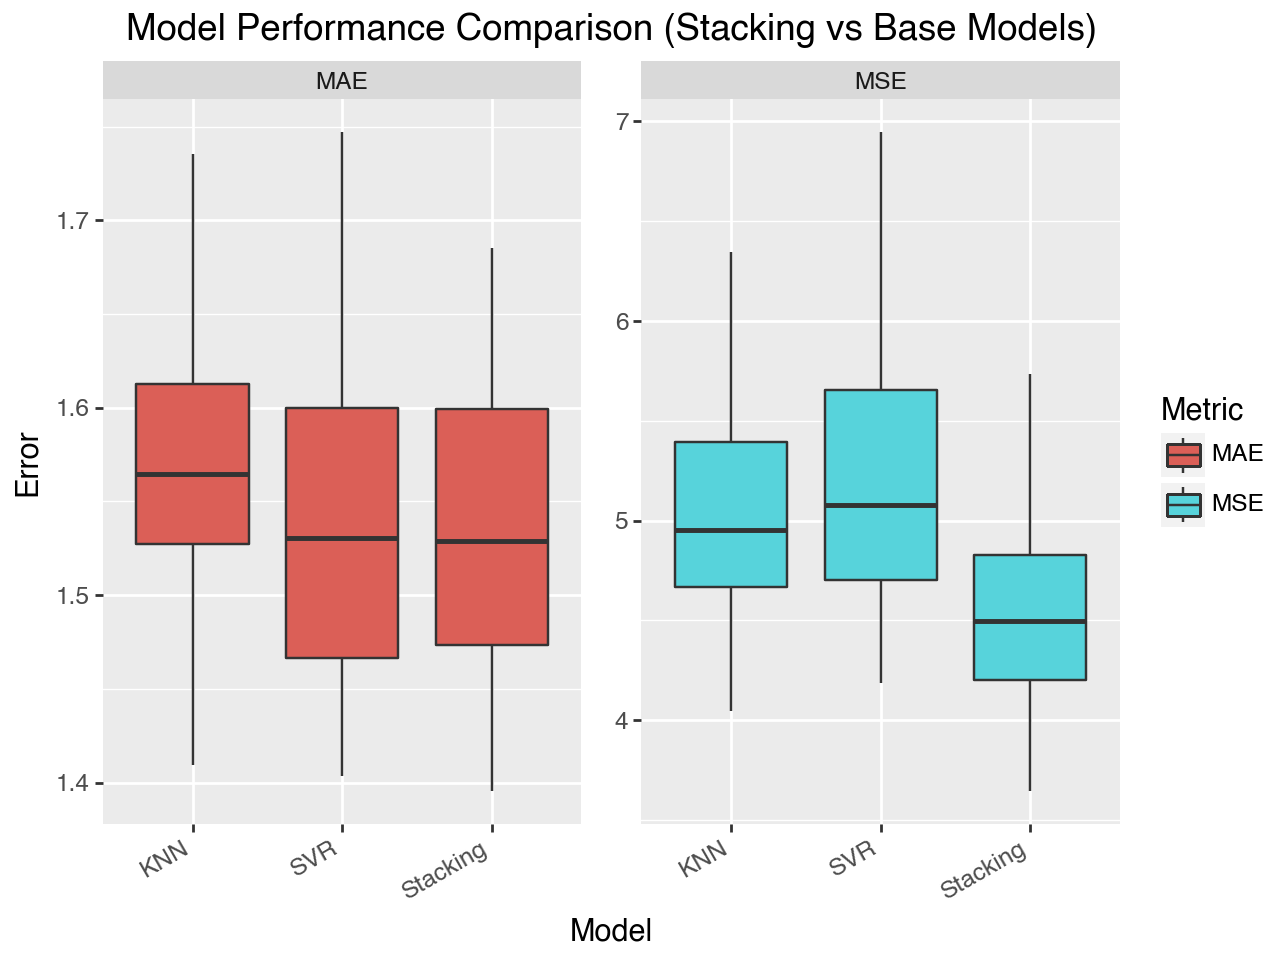

In [13]:
import pandas as pd
from plotnine import *

# Flatten MAE and MSE results into a DataFrame
mae_df = pd.DataFrame([(model, score) for model, scores in mae_results.items() for score in scores], columns=['Model', 'MAE'])
mse_df = pd.DataFrame([(model, score) for model, scores in mse_results.items() for score in scores], columns=['Model', 'MSE'])

# Merge for long format
df_long = pd.merge(mae_df, mse_df, on=['Model'])
df_long = pd.melt(df_long, id_vars='Model', value_vars=['MAE', 'MSE'], var_name='Metric', value_name='Error')

# Plot with ggplot
plot = (
    ggplot(df_long, aes(x='Model', y='Error', fill='Metric'))
    + geom_boxplot()
    + facet_wrap('~Metric', scales='free_y')
    + labs(title='Model Performance Comparison (Stacking vs Base Models)', y='Error', x='Model')
    + theme(axis_text_x=element_text(rotation=30, ha='right'))
)
plot.show()


I found that that there is little variation between the bagging method and stacking method based on my execution. But have also found that the two methods did better than teh stand alone models.